In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-21 20:08:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.168.197, 52.216.208.152, 52.217.203.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.168.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.44MB/s    in 2.4s    

2024-07-21 20:08:08 (5.44 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

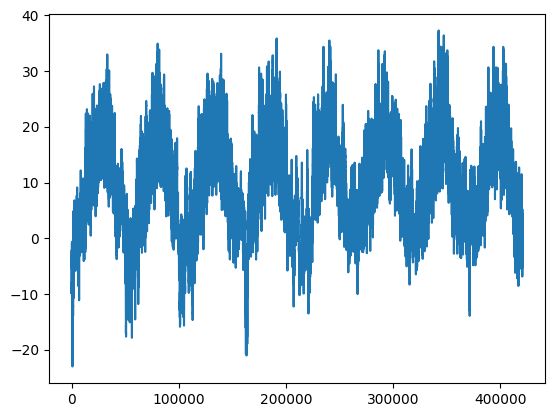

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

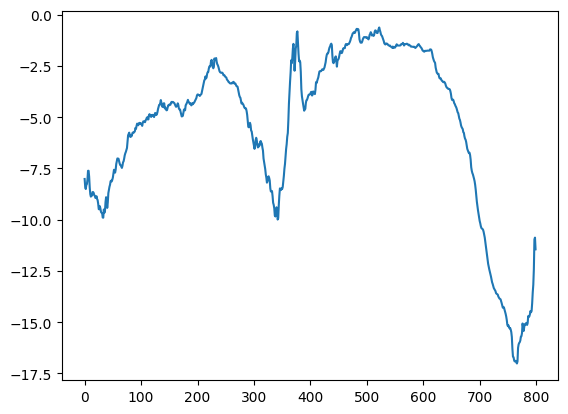

In [5]:
plt.plot(range(800), temperature[:800])

In [6]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
import keras
from keras import layers

In [ ]:
import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 549s 662ms/step - loss: 24.7314 - mae: 3.6831 - val_loss: 9.4374 - val_mae: 2.3809
Epoch 2/10
819/819 [==============================] - 542s 661ms/step - loss: 14.2094 - mae: 2.9169 - val_loss: 8.9544 - val_mae: 2.3108
Epoch 3/10
819/819 [==============================] - 538s 657ms/step - loss: 13.3416 - mae: 2.8292 - val_loss: 8.6640 - val_mae: 2.2759
Epoch 4/10
819/819 [==============================] - 537s 656ms/step - loss: 12.6966 - mae: 2.7618 - val_loss: 9.1247 - val_mae: 2.3488
Epoch 5/10
819/819 [==============================] - 543s 663ms/step - loss: 12.2451 - mae: 2.7169 - val_loss: 8.8370 - val_mae: 2.3042
Epoch 6/10
819/819 [==============================] - 533s 650ms/step - loss: 11.8995 - mae: 2.6765 - val_loss: 9.4966 - val_mae: 2.4020
Epoch 7/10
819/819 [==============================] - 531s 648ms/step - loss: 11.4781 - mae: 2.6314 - val_loss: 8.6976 - val_mae: 2.2882
Epoch 8/10
819/819 [=====================

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 120, 32)           4608      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 10977 (42.88 KB)
Trainable params: 10977 (42.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


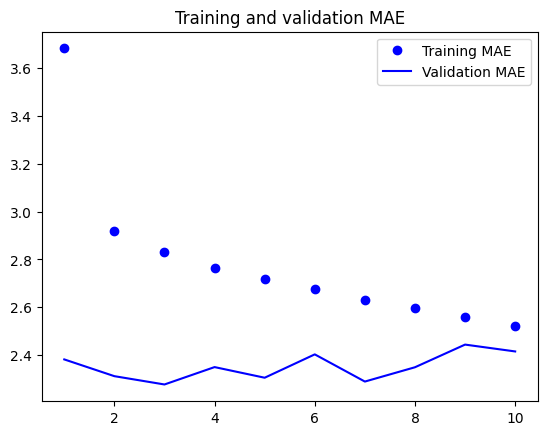

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 42s 102ms/step - loss: 9.7024 - mae: 2.4299
Test MAE: 2.43


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 553s 671ms/step - loss: 43.4996 - mae: 4.8605 - val_loss: 12.9024 - val_mae: 2.6766
Epoch 2/10
819/819 [==============================] - 540s 659ms/step - loss: 18.6235 - mae: 3.2957 - val_loss: 10.3436 - val_mae: 2.4874
Epoch 3/10
819/819 [==============================] - 536s 654ms/step - loss: 17.1730 - mae: 3.1771 - val_loss: 9.2327 - val_mae: 2.3415
Epoch 4/10
819/819 [==============================] - 521s 636ms/step - loss: 16.3330 - mae: 3.0997 - val_loss: 9.0943 - val_mae: 2.3248
Epoch 5/10
819/819 [==============================] - 506s 618ms/step - loss: 15.7352 - mae: 3.0449 - val_loss: 9.6993 - val_mae: 2.4054
Epoch 6/10
819/819 [==============================] - 506s 617ms/step - loss: 15.1846 - mae: 2.9914 - val_loss: 8.7994 - val_mae: 2.2955
Epoch 7/10
819/819 [==============================] - 503s 614ms/step - loss: 14.7631 - mae: 2.9526 - val_loss: 8.9125 - val_mae: 2.3155
Epoch 8/10
819/819 [===================

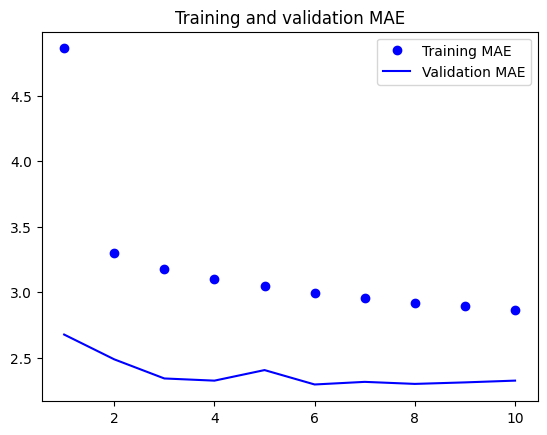

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 41s 100ms/step - loss: 9.9280 - mae: 2.4454
Test MAE: 2.45


In [12]:
import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(64, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 539s 649ms/step - loss: 16.7293 - mae: 3.0846 - val_loss: 9.9022 - val_mae: 2.4546
Epoch 2/10
819/819 [==============================] - 525s 641ms/step - loss: 11.4190 - mae: 2.6378 - val_loss: 8.8908 - val_mae: 2.3189
Epoch 3/10
819/819 [==============================] - 524s 639ms/step - loss: 10.4814 - mae: 2.5256 - val_loss: 8.8036 - val_mae: 2.2946
Epoch 4/10
819/819 [==============================] - 521s 636ms/step - loss: 9.6004 - mae: 2.4207 - val_loss: 9.3279 - val_mae: 2.3695
Epoch 5/10
819/819 [==============================] - 537s 655ms/step - loss: 8.9016 - mae: 2.3272 - val_loss: 10.4663 - val_mae: 2.5322
Epoch 6/10
819/819 [==============================] - 526s 642ms/step - loss: 8.2514 - mae: 2.2405 - val_loss: 10.2830 - val_mae: 2.5021
Epoch 7/10
819/819 [==============================] - 532s 649ms/step - loss: 7.7653 - mae: 2.1680 - val_loss: 10.3590 - val_mae: 2.5106
Epoch 8/10
819/819 [======================

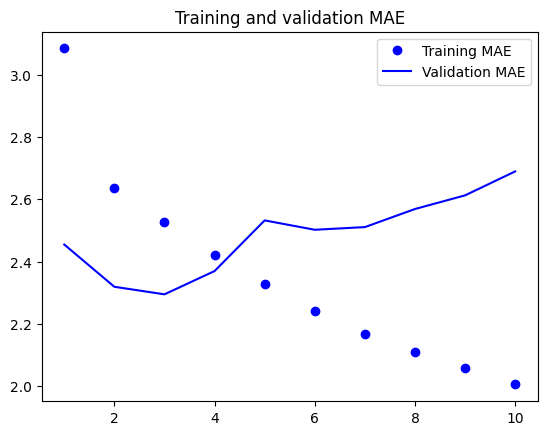

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 40s 96ms/step - loss: 9.6548 - mae: 2.4486
Test MAE: 2.45


In [15]:
from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)


Epoch 1/10
819/819 [==============================] - 41s 48ms/step - loss: 50.2098 - mae: 5.2180 - val_loss: 14.6997 - val_mae: 2.8904
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 11.6970 - mae: 2.6423 - val_loss: 9.9660 - val_mae: 2.4573
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 9.8180 - mae: 2.4401 - val_loss: 10.2836 - val_mae: 2.4650
Epoch 4/10
819/819 [==============================] - 39s 48ms/step - loss: 9.3369 - mae: 2.3810 - val_loss: 10.3642 - val_mae: 2.4709
Epoch 5/10
819/819 [==============================] - 48s 59ms/step - loss: 9.0180 - mae: 2.3403 - val_loss: 9.7985 - val_mae: 2.4138
Epoch 6/10
819/819 [==============================] - 38s 47ms/step - loss: 8.7829 - mae: 2.3065 - val_loss: 9.6667 - val_mae: 2.4229
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 8.5458 - mae: 2.2734 - val_loss: 10.0146 - val_mae: 2.4579
Epoch 8/10
819/819 [==============================] - 47

In [16]:
model.evaluate(test_dataset)

405/405 [==============================] - 12s 29ms/step - loss: 11.5087 - mae: 2.6534


[11.508743286132812, 2.6533637046813965]

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (7.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


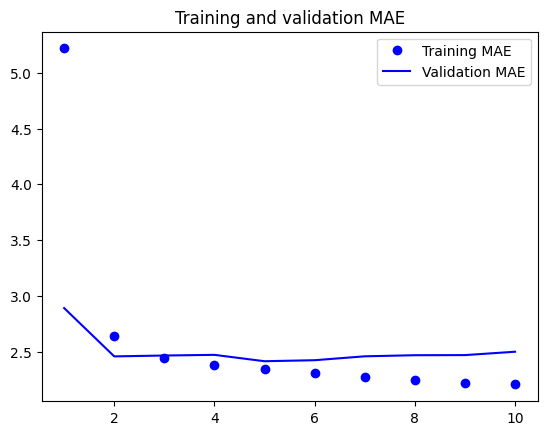

In [18]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
input_shape = (120, 14)
inputs = keras.Input(shape=input_shape)
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
819/819 [==============================] - 53s 59ms/step - loss: 32.4933 - mae: 4.3274 - val_loss: 15.7913 - val_mae: 3.0969
Epoch 2/10
819/819 [==============================] - 47s 56ms/step - loss: 17.9659 - mae: 3.3152 - val_loss: 15.1055 - val_mae: 3.0519
Epoch 3/10
819/819 [==============================] - 38s 47ms/step - loss: 16.0880 - mae: 3.1222 - val_loss: 17.1991 - val_mae: 3.2449
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 15.1345 - mae: 3.0148 - val_loss: 15.4388 - val_mae: 3.0610
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 14.1708 - mae: 2.9113 - val_loss: 15.6980 - val_mae: 3.0833
Epoch 6/10
819/819 [==============================] - 38s 46ms/step - loss: 13.4873 - mae: 2.8332 - val_loss: 15.1433 - val_mae: 3.0542
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 12.9562 - mae: 2.7742 - val_loss: 15.8879 - val_mae: 3.1202
Epoch 8/10
819/819 [============================

[21.246078491210938, 3.6266119480133057]

In [20]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

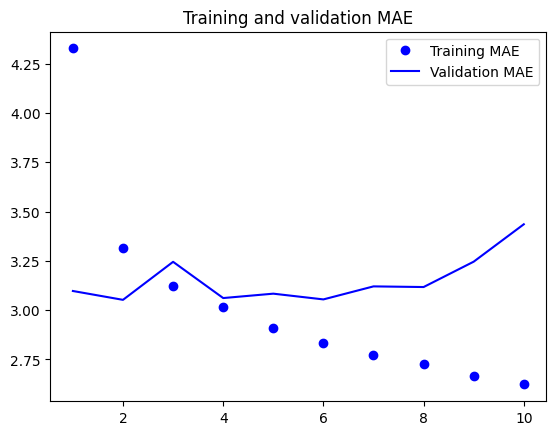

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
819/819 [==============================] - 48s 54ms/step - loss: 25.2775 - mae: 3.6118 - val_loss: 10.6692 - val_mae: 2.5461
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 9.5365 - mae: 2.3996 - val_loss: 9.5582 - val_mae: 2.4063
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 8.5309 - mae: 2.2687 - val_loss: 9.6124 - val_mae: 2.4091
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 7.9970 - mae: 2.1955 - val_loss: 9.8200 - val_mae: 2.4361
Epoch 5/10
819/819 [==============================] - 42s 52ms/step - loss: 7.6607 - mae: 2.1448 - val_loss: 10.0802 - val_mae: 2.4672
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 7.3528 - mae: 2.1001 - val_loss: 9.7007 - val_mae: 2.4177
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 7.1043 - mae: 2.0619 - val_loss: 10.3573 - val_mae: 2.5025
Epoch 8/10
819/819 [==============================] - 44s 

[12.076170921325684, 2.7249820232391357]

In [23]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 bidirectional (Bidirection  (None, 32)                3968      
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4001 (15.63 KB)
Trainable params: 4001 (15.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


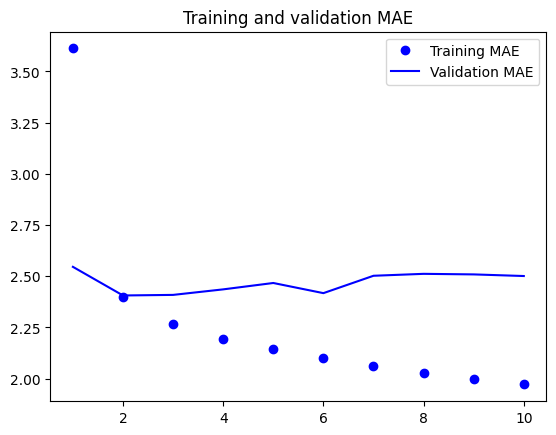

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()